In [2]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier


import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [5]:
!unzip -q career-con-2019.zip

In [6]:
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
Y_train = pd.read_csv("y_train.csv")

In [7]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [8]:
Y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [9]:
X_test.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,0.91208,-0.38193,-0.050618,0.14028,-0.060205,0.071286,-0.18787,0.29492,2.8027,-9.6816
1,0_1,0,1,0.91220,-0.38165,-0.050573,0.14028,-0.033486,0.060210,-0.18206,0.14944,2.5408,-9.8521
2,0_2,0,2,0.91228,-0.38143,-0.050586,0.14032,-0.029686,0.029476,-0.18441,-0.49741,2.5853,-9.3835
3,0_3,0,3,0.91237,-0.38121,-0.050588,0.14035,-0.024217,0.037788,-0.18783,-0.32376,2.9966,-8.7415
4,0_4,0,4,0.91247,-0.38096,-0.050546,0.14042,-0.038047,0.083405,-0.20170,-0.70103,2.6498,-8.8432


In [10]:
print("Train X: {}\nTrain y: {}\nTest X: {}".format(X_train.shape, Y_train.shape, X_test.shape))

Train X: (487680, 13)
Train y: (3810, 3)
Test X: (488448, 13)


## Data Exploration

In [11]:
Y_train['surface'].value_counts()

concrete                  779
soft_pvc                  732
wood                      607
tiled                     514
fine_concrete             363
hard_tiles_large_space    308
soft_tiles                297
carpet                    189
hard_tiles                 21
Name: surface, dtype: int64

In [12]:
X_train.isna().sum()

row_id                   0
series_id                0
measurement_number       0
orientation_X            0
orientation_Y            0
orientation_Z            0
orientation_W            0
angular_velocity_X       0
angular_velocity_Y       0
angular_velocity_Z       0
linear_acceleration_X    0
linear_acceleration_Y    0
linear_acceleration_Z    0
dtype: int64

In [13]:
X_test.isna().sum()

row_id                   0
series_id                0
measurement_number       0
orientation_X            0
orientation_Y            0
orientation_Z            0
orientation_W            0
angular_velocity_X       0
angular_velocity_Y       0
angular_velocity_Z       0
linear_acceleration_X    0
linear_acceleration_Y    0
linear_acceleration_Z    0
dtype: int64

In [14]:
Y_train.isna().sum()

series_id    0
group_id     0
surface      0
dtype: int64

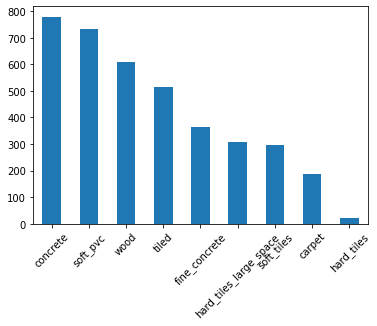

In [15]:
Y_train.surface.value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.show()

In [29]:
le = LabelEncoder()
Y_train['surface'] = le.fit_transform(Y_train['surface'])

In [30]:
Y_train.head()

,series_id,group_id,surface
0,0,13,2
1,1,31,1
2,2,20,1
3,3,31,1
4,4,22,6


##Feature Engineering

In [17]:
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

In [18]:
def perform_feature_engineering(actual):
    new = pd.DataFrame()
    actual['total_angular_velocity'] = (actual['angular_velocity_X'] ** 2 + actual['angular_velocity_Y'] ** 2 + actual['angular_velocity_Z'] ** 2) ** 0.5
    actual['total_linear_acceleration'] = (actual['linear_acceleration_X'] ** 2 + actual['linear_acceleration_Y'] ** 2 + actual['linear_acceleration_Z'] ** 2) ** 0.5
    
    actual['acc_vs_vel'] = actual['total_linear_acceleration'] / actual['total_angular_velocity']
    
    x, y, z, w = actual['orientation_X'].tolist(), actual['orientation_Y'].tolist(), actual['orientation_Z'].tolist(), actual['orientation_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    actual['euler_x'] = nx
    actual['euler_y'] = ny
    actual['euler_z'] = nz
    
    actual['total_angle'] = (actual['euler_x'] ** 2 + actual['euler_y'] ** 2 + actual['euler_z'] ** 2) ** 5
    actual['angle_vs_acc'] = actual['total_angle'] / actual['total_linear_acceleration']
    actual['angle_vs_vel'] = actual['total_angle'] / actual['total_angular_velocity']

    def mean_change_of_abs_change(x):
        return np.mean(np.diff(np.abs(np.diff(x))))

    def mean_abs_change(x):
        return np.mean(np.abs(np.diff(x)))
    
    for col in actual.columns:
        if col in ['row_id', 'series_id', 'measurement_number']:
            continue
        new[col + '_mean'] = actual.groupby(['series_id'])[col].mean()
        new[col + '_min'] = actual.groupby(['series_id'])[col].min()
        new[col + '_max'] = actual.groupby(['series_id'])[col].max()
        new[col + '_std'] = actual.groupby(['series_id'])[col].std()
        new[col + '_max_to_min'] = new[col + '_max'] / new[col + '_min']
        
        # Change. 1st order.
        new[col + '_mean_abs_change'] = actual.groupby('series_id')[col].apply(mean_abs_change)

        # Change of Change. 2nd order.
        new[col + '_mean_change_of_abs_change'] = actual.groupby('series_id')[col].apply(mean_change_of_abs_change)
        
        new[col + '_abs_max'] = actual.groupby('series_id')[col].apply(lambda x: np.max(np.abs(x)))
        new[col + '_abs_min'] = actual.groupby('series_id')[col].apply(lambda x: np.min(np.abs(x)))

    return new

In [19]:
X_train = perform_feature_engineering(X_train)
X_test = perform_feature_engineering(X_test)

In [20]:
X_train.head()

,orientation_X_mean,orientation_X_min,orientation_X_max,orientation_X_std,orientation_X_max_to_min,orientation_X_mean_abs_change,orientation_X_mean_change_of_abs_change,orientation_X_abs_max,orientation_X_abs_min,orientation_Y_mean,...,angle_vs_acc_abs_min,angle_vs_vel_mean,angle_vs_vel_min,angle_vs_vel_max,angle_vs_vel_std,angle_vs_vel_max_to_min,angle_vs_vel_mean_abs_change,angle_vs_vel_mean_change_of_abs_change,angle_vs_vel_abs_max,angle_vs_vel_abs_min
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,-0.75953,-0.75822,0.000363,0.998275,0.000015,2.380952e-07,0.75953,0.75822,-0.634008,...,8090.592033,2.278501e+06,6.255962e+05,9.597909e+06,1.409996e+06,15.342019,1.198969e+06,8924.000999,9.597909e+06,6.255962e+05
1,-0.958606,-0.95896,-0.95837,0.000151,0.999385,0.000023,-4.761905e-07,0.95896,0.95837,0.241867,...,2339.913394,4.613413e+05,1.377975e+05,1.957088e+06,2.979271e+05,14.202636,2.049951e+05,569.164381,1.957088e+06,1.377975e+05
2,-0.512057,-0.51434,-0.50944,0.001377,0.990473,0.000041,0.000000e+00,0.51434,0.50944,-0.846171,...,22485.416514,5.372327e+06,1.674839e+06,2.866679e+07,3.802655e+06,17.116144,2.355426e+06,-9135.272306,2.866679e+07,1.674839e+06
3,-0.939169,-0.93968,-0.93884,0.000227,0.999106,0.000026,-6.349206e-07,0.93968,0.93884,0.310140,...,2157.840573,4.765087e+05,8.652378e+04,3.121275e+06,4.627398e+05,36.074189,2.981020e+05,17412.401283,3.121275e+06,8.652378e+04
4,-0.891301,-0.89689,-0.88673,0.002955,0.988672,0.000080,7.936508e-08,0.89689,0.88673,0.428144,...,4804.885067,3.694817e+05,2.330043e+05,6.165090e+05,9.199986e+04,2.645912,2.281891e+04,-70.793166,6.165090e+05,2.330043e+05


In [21]:
X_test.head()

,orientation_X_mean,orientation_X_min,orientation_X_max,orientation_X_std,orientation_X_max_to_min,orientation_X_mean_abs_change,orientation_X_mean_change_of_abs_change,orientation_X_abs_max,orientation_X_abs_min,orientation_Y_mean,...,angle_vs_acc_abs_min,angle_vs_vel_mean,angle_vs_vel_min,angle_vs_vel_max,angle_vs_vel_std,angle_vs_vel_max_to_min,angle_vs_vel_mean_abs_change,angle_vs_vel_mean_change_of_abs_change,angle_vs_vel_abs_max,angle_vs_vel_abs_min
series_id,,,,,,,,,,,,,,,,,,,,,
0,0.919651,0.912080,0.92796,0.004669,1.017411,0.000125,0.000000e+00,0.92796,0.912080,-0.362914,...,4225.689066,1.803967e+05,1.234749e+05,2.641645e+05,29891.973999,2.139418,7865.563541,-139.762402,2.641645e+05,1.234749e+05
1,0.043135,-0.024045,0.10948,0.039537,-4.553130,0.001051,-3.412698e-07,0.10948,0.000013,-0.987147,...,117178.617377,1.878296e+06,1.531338e+06,2.345838e+06,234544.916260,1.531888,28910.111390,-239.920114,2.345838e+06,1.531338e+06
2,-0.914825,-0.915200,-0.91438,0.000259,0.999104,0.000016,3.174603e-07,0.91520,0.914380,0.376669,...,3377.231807,7.376186e+05,1.714854e+05,4.021349e+06,540483.609891,23.450098,331334.420374,-4446.837619,4.021349e+06,1.714854e+05
3,0.928206,0.911760,0.94376,0.009408,1.035097,0.000252,-3.174603e-07,0.94376,0.911760,0.338873,...,3991.355661,7.630515e+04,6.732007e+04,9.132614e+04,5542.215483,1.356596,1335.451462,12.062972,9.132614e+04,6.732007e+04
4,-0.869592,-0.870950,-0.86895,0.000456,0.997704,0.000046,-3.174603e-07,0.87095,0.868950,0.470784,...,4570.079062,5.767760e+05,2.230404e+05,2.063618e+06,310880.891102,9.252214,179422.994438,891.189263,2.063618e+06,2.230404e+05


In [23]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [24]:
params = {'n_estimators': 800, 'min_samples_leaf': 1, 'max_depth': 20}

In [32]:
sub_preds_rf = np.zeros((X_test.shape[0], 9))
oof_preds_rf = np.zeros((X_train.shape[0]))
score = 0
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, Y_train['surface'])):
    clf =  RandomForestClassifier(**params)
    clf.fit(X_train.iloc[trn_idx], Y_train['surface'][trn_idx])
    oof_preds_rf[val_idx] = clf.predict(X_train.iloc[val_idx])
    sub_preds_rf += clf.predict_proba(X_test) / folds.n_splits
    score += clf.score(X_train.iloc[val_idx], Y_train['surface'][val_idx])
    print('Fold: {} score: {}'.format(fold_,clf.score(X_train.iloc[val_idx], Y_train['surface'][val_idx])))
print('Avg Accuracy', score / folds.n_splits)

Fold: 0 score: 0.9291338582677166
Fold: 1 score: 0.9133858267716536
Fold: 2 score: 0.9212598425196851
Fold: 3 score: 0.884514435695538
Fold: 4 score: 0.9133858267716536
Fold: 5 score: 0.910761154855643
Fold: 6 score: 0.937007874015748
Fold: 7 score: 0.9238845144356955
Fold: 8 score: 0.8976377952755905
Fold: 9 score: 0.9186351706036745
Avg Accuracy 0.91496062992126
